<a href="https://colab.research.google.com/github/edmenciab733/ecc_qiskit_fallfest/blob/main/challenge_quantumquipu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paquetes requeridos

In [1]:
%%capture
!pip install qiskit
!pip install pylatexenc
!pip install qiskit-aer
!pip install pennylane
!pip install ipython-autotime
!python -m pip install pennylane pennylane-lightning-gpu custatevec-cu11 --upgrade
!pip install qiskit-machine-learning

In [2]:
%load_ext autotime

time: 353 µs (started: 2023-11-12 17:19:40 +00:00)


In [3]:
import pandas as pd
import pennylane  as qml
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

time: 2.8 s (started: 2023-11-12 17:19:40 +00:00)


# Datos

In [4]:
df_train = pd.read_csv("https://raw.githubusercontent.com/QuantumQuipu/QuantumChallenge/main/challenge_train.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/QuantumQuipu/QuantumChallenge/main/challenge_test.csv")

time: 457 ms (started: 2023-11-12 17:19:42 +00:00)


In [5]:
df_train.drop(df_train.columns[0], axis=1, inplace=True)
df_test.drop(df_test.columns[0], axis=1, inplace=True)

time: 14.5 ms (started: 2023-11-12 17:19:43 +00:00)


In [6]:
df_test.head()

,F1,F2,F3,F4,Target
0,1.866088,1.574254,0.138930,-0.351542,1
1,0.839427,-1.069518,-0.432655,-0.964800,0
2,0.557187,-0.921264,-0.379198,-0.003020,0
3,-0.694573,1.875495,0.533211,0.659735,1
4,-1.844339,-1.116098,1.074549,-0.156043,0


time: 12.2 ms (started: 2023-11-12 17:19:43 +00:00)


In [7]:
print(df_train.shape, df_test.shape)

(800, 5) (200, 5)
time: 657 µs (started: 2023-11-12 17:19:43 +00:00)


## Datos Balanceados

<Axes: >

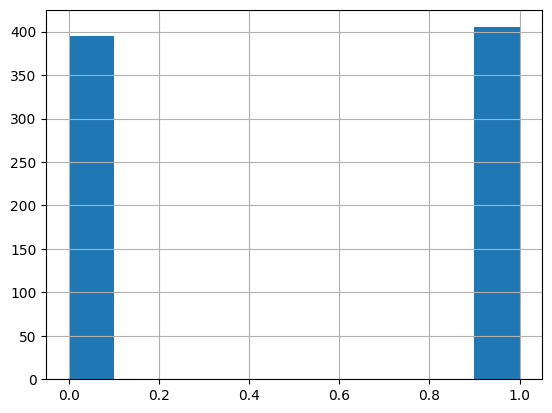

time: 377 ms (started: 2023-11-12 17:19:43 +00:00)


In [8]:
df_train["Target"].hist()

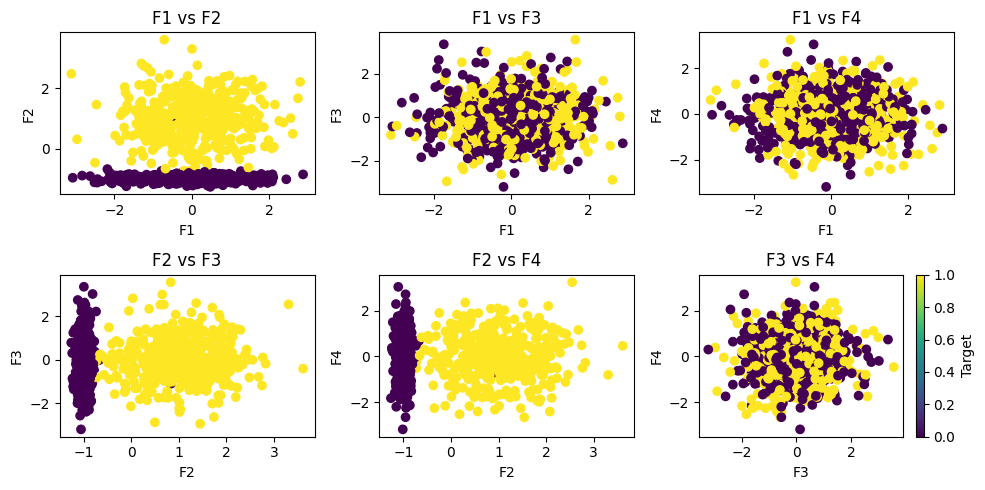

time: 1.71 s (started: 2023-11-12 17:19:43 +00:00)


In [9]:
features = ['F1', 'F2', 'F3', 'F4']


fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes = axes.ravel()

# Crear los gráficos
for i, (feature1, feature2) in enumerate(combinations(features, 2)):
    ax = axes[i]
    scatter = ax.scatter(df_train[feature1], df_train[feature2], c=df_train['Target'])
    ax.set_title(f'{feature1} vs {feature2}')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])


fig.colorbar(scatter, label='Target')

# Mostrar el gráfico
plt.tight_layout()  # Ajusta automáticamente los parámetros del subplot
plt.show()


## PCA

[1.49141493 1.07626371 0.98609999 0.92975252 0.0486541 ]
[32.90719263 23.74712524 21.75771594 20.51444213  1.07352406]
[ 32.90719263  56.65431787  78.41203381  98.92647594 100.        ]


Text(0, 0.5, 'Varianza explicada Acumulada')

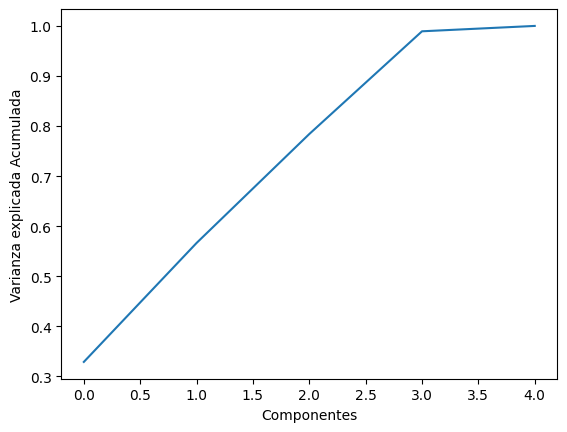

time: 399 ms (started: 2023-11-12 17:22:19 +00:00)


In [10]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_train)
X = pca.transform(df_train)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_ * 100)
print(pca.explained_variance_ratio_.cumsum() *100)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Componentes')
plt.ylabel('Varianza explicada Acumulada')
# Con el pca, notamos que con dos dimensiones se puede explicar el 97 por ciento de la varianza de las muestras. Lo que se puede verificar en la propia gráfica anterior, ya que todas
# combinaciones de dos dimensiones.
# Ademas se hacen precisiones con un modelo de Arbol de Desición, la intención es demostrar que tanto de precisión, se pierde o gana como menos columnas.

Las 3 primeras columnas explican lo 98% de los datos para el tanto para El AngleEmbedding como el ZZFeaturedMap podriamos usar solo 3 qubits. Inicialmente probaremos con la totalidad pero más abajo veremos si el mejor modelo es uno de los, podriamos reducir el tiempo sin ver que se pierdo tanto acurracy

## Datos adicionales de la composición de nuestros datos

In [11]:
df_train.describe()

,F1,F2,F3,F4,Target
count,800.000000,800.000000,800.000000,800.000000,800.000000
mean,-0.022675,0.018758,0.011646,-0.020326,0.506250
std,1.003272,1.128938,1.030749,0.968716,0.500274
min,-3.118159,-1.263462,-3.213591,-3.197503,0.000000
25%,-0.713586,-0.995735,-0.680477,-0.652490,0.000000
50%,-0.021669,-0.508522,-0.003524,-0.011651,1.000000
75%,0.660294,1.000536,0.694698,0.645487,1.000000
max,2.879529,3.612707,3.561504,3.249360,1.000000


time: 22.1 ms (started: 2023-11-12 17:22:24 +00:00)


## Prepapración de los datos

In [12]:
x_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values
x_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

time: 1.91 ms (started: 2023-11-12 17:22:31 +00:00)


In [13]:
scaler = MaxAbsScaler()
x_trscaler = scaler.fit_transform(x_train)

time: 1.35 ms (started: 2023-11-12 17:22:32 +00:00)


In [14]:
df_train["Target"].value_counts()

1    405
0    395
Name: Target, dtype: int64

time: 5.46 ms (started: 2023-11-12 17:22:33 +00:00)


In [15]:
x_trscaler

array([[-0.09351405,  0.51335636, -0.06345758,  0.52156551],
       [ 0.10503011,  0.43865928, -0.36516632,  0.14517601],
       [ 0.07311527,  0.41852907, -0.18166023, -0.22887792],
       ...,
       [ 0.21745571, -0.28535903, -0.33957967,  0.39072768],
       [-0.32939082,  0.14265007,  0.32825804, -0.47205864],
       [ 0.27475071,  0.45982156,  0.03640087, -0.21937293]])

time: 4.26 ms (started: 2023-11-12 17:22:35 +00:00)


In [ ]:
x_tescaler = scaler.transform(x_test)

In [17]:
print(np.min(x_trscaler), np.max(x_trscaler))

-1.0 1.0
time: 1.14 ms (started: 2023-11-12 17:22:38 +00:00)


In [18]:
print(np.min(x_tescaler), np.max(x_tescaler))

-1.0 1.0
time: 670 µs (started: 2023-11-12 17:22:39 +00:00)


# Encodig

## Amplitud Embedding

In [ ]:
nqubits = 2
dev = qml.device("lightning.gpu", wires=nqubits)
@qml.qnode(dev)
def kernel_circuit_amplitude(a,b):
  normalize= True
  qml.AmplitudeEmbedding(a, wires=range(nqubits), normalize=normalize)
  qml.adjoint( qml.AmplitudeEmbedding(b, wires=range(nqubits), normalize=normalize) )
  return qml.probs(wires= range(nqubits))

time: 4.87 ms (started: 2023-11-11 23:55:56 +00:00)


In [ ]:
drawer = qml.draw(kernel_circuit_amplitude)
print(drawer(x_trscaler[0], x_trscaler[3]))

0: ─╭|Ψ⟩─╭|Ψ⟩†─┤ ╭Probs
1: ─╰|Ψ⟩─╰|Ψ⟩†─┤ ╰Probs
time: 45.5 ms (started: 2023-11-11 23:30:13 +00:00)


In [ ]:
kernel_circuit_amplitude(x_trscaler[0], x_trscaler[1]), kernel_circuit_amplitude(x_trscaler[0], x_trscaler[0])

(array([0.50326073, 0.38870318, 0.02799519, 0.0800409 ]),
 array([1.00000000e+00, 4.96867485e-32, 7.03479004e-33, 6.10562578e-32]))

time: 22 ms (started: 2023-11-11 23:30:15 +00:00)


## Angle Embedding

In [ ]:
nqubits = 4
dev = qml.device("lightning.gpu", wires=nqubits)
@qml.qnode(dev)
def kernel_circuit_angle(a,b):
  qml.AngleEmbedding(a, wires=range(nqubits))
  qml.adjoint( qml.AngleEmbedding(b, wires=range(nqubits)) )
  return qml.probs(wires= range(nqubits))

time: 6.67 ms (started: 2023-11-12 01:11:49 +00:00)


In [ ]:
drawer = qml.draw(kernel_circuit_angle)
print(drawer(x_trscaler[0], x_trscaler[3]))

0: ─╭AngleEmbedding(M0)─╭AngleEmbedding(M1)†─┤ ╭Probs
1: ─├AngleEmbedding(M0)─├AngleEmbedding(M1)†─┤ ├Probs
2: ─├AngleEmbedding(M0)─├AngleEmbedding(M1)†─┤ ├Probs
3: ─╰AngleEmbedding(M0)─╰AngleEmbedding(M1)†─┤ ╰Probs
M0 = 
[-0.09351405  0.51335636 -0.06345758  0.52156551]
M1 = 
[-0.14544626  0.50351198 -0.24454744 -0.44697715]
time: 84.8 ms (started: 2023-11-12 01:12:14 +00:00)


## ZFeaturedMap

In [44]:
from itertools import combinations
def ZZFeatureMap(nqubits, data):
  nload = min(len(data), nqubits)
  for i in range(nload):
    qml.Hadamard(i)
    qml.RZ(2* data[i], wires = i)
  for pair in list(combinations(range(nload), 2 )):
    q0 = pair[0]
    q1 = pair[1]
    qml.CZ(wires=[q0, q1])
    qml.RZ(2* (np.pi -  data[q0]) * (np.pi -  data[q1]), wires = q1)
    qml.CZ(wires = [q0, q1])


nqubits = 4
dev = qml.device("lightning.gpu", wires=nqubits)
@qml.qnode(dev)
def kernel_circuit_zzfeature_map(a,b):
  ZZFeatureMap(nqubits, a)
  qml.adjoint(ZZFeatureMap)(nqubits, b)
  return qml.probs(wires= range(nqubits))

time: 10.6 ms (started: 2023-11-12 01:48:13 +00:00)


# SVM

In [ ]:
from sklearn import svm
svm  = svm.SVC().fit(x_trscaler, y_train)

time: 111 ms (started: 2023-11-11 23:41:46 +00:00)


In [ ]:
y_predict = svm.predict(x_tescaler)
print(accuracy_score (y_predict, y_test ))

0.98
time: 7.26 ms (started: 2023-11-11 23:42:09 +00:00)


#QSVM

In [ ]:
x_trscaler.shape

(800, 4)

time: 7.28 ms (started: 2023-11-11 23:55:11 +00:00)


In [ ]:
from sklearn.svm import SVC

def qkernel(A, B):
  return np.array([[ kernel_circuit_amplitude(a, b) [0] for b in B ] for a in A])

svm = SVC(kernel = qkernel).fit(x_trscaler, y_train)

time: 57min 16s (started: 2023-11-11 23:56:08 +00:00)


In [ ]:
y_predict = svm.predict(x_tescaler)
print(accuracy_score(y_predict, y_test ))

0.51
time: 13min 37s (started: 2023-11-12 00:54:28 +00:00)


In [ ]:
def qkernel(A, B):
  return np.array([[ kernel_circuit_angle(a, b) [0] for b in B ] for a in A])

svm = SVC(kernel = qkernel).fit(x_trscaler, y_train)

time: 22min 1s (started: 2023-11-12 01:13:04 +00:00)


In [ ]:
y_predict = svm.predict(x_tescaler)
print(accuracy_score(y_predict, y_test ))

0.975
time: 5min 32s (started: 2023-11-12 01:35:44 +00:00)


In [45]:
def qkernel(A, B):
  return np.array([[ kernel_circuit_zzfeature_map(a, b) [0] for b in B ] for a in A])

svm = SVC(kernel = qkernel).fit(x_trscaler, y_train)

time: 1h 40min 39s (started: 2023-11-12 01:48:21 +00:00)


In [47]:
y_predict = svm.predict(x_tescaler)
print(accuracy_score(y_predict, y_test ))

0.785
time: 24min 46s (started: 2023-11-12 03:35:15 +00:00)


## ZZFeatureMap  - Qiskit

In [19]:
from qiskit import *
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel


time: 632 ms (started: 2023-11-12 17:23:06 +00:00)


<ipython-input-19-8c33754fbaa1>:2: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.state_fidelities import ComputeUncompute


In [20]:
fidelity = ComputeUncompute(sampler=Sampler())
zzfm = ZZFeatureMap(4)
new_kernel = FidelityQuantumKernel(feature_map=zzfm, fidelity=fidelity)

time: 23.5 ms (started: 2023-11-12 17:23:07 +00:00)


In [ ]:
from qiskit_machine_learning.algorithms import QSVC
qsvc = QSVC(quantum_kernel=new_kernel)
qsvc.fit(x_trscaler, y_train)

In [ ]:
y_predict = qsvc.predict(x_tescaler )
print(accuracy_score(y_predict, y_test ))

## Modelo ganador AngleEmbedding con PCA

In [ ]:
nqubits = 3
dev = qml.device("lightning.gpu", wires=nqubits)
@qml.qnode(dev)
def kernel_circuit_angle(a,b):
  qml.AngleEmbedding(a, wires=range(nqubits))
  qml.adjoint( qml.AngleEmbedding(b, wires=range(nqubits)) )
  return qml.probs(wires= range(nqubits))



In [ ]:
x_train = df_train.iloc[:, :-2].values
y_train = df_train.iloc[:, -1].values
x_test = df_test.iloc[:, :-2].values
y_test = df_test.iloc[:, -1].values

In [ ]:
scaler = MaxAbsScaler()
x_trscaler = scaler.fit_transform(x_train)
x_tescaler = scaler.transform(x_test)

In [ ]:
from sklearn.svm import SVC

def qkernel(A, B):
  return np.array([[ kernel_circuit_angle(a, b) [0] for b in B ] for a in A])

svm = SVC(kernel = qkernel).fit(x_trscaler, y_train)

# Conclusiones

Para este grupo de datos, la implementación funciona es el SVM clásico. El acuraccy es del 98%. En un tiempo de ajuste del modelo de 7.26 ms.

Para los modelos tipo QSVM

El modelo de embbeging ha sido mucho siendo el modelo aquel que aplica el AngleEmbbeding con un tiempo de compilación de 22min 1s y un 97.5% de acurracy

